In [1]:
# include useful folders
import sys

In [2]:
sys.path.append("../vendors/mtl_girnet/data_prep/")
sys.path.append("../src/language-model/")

In [3]:
# enable or disable cuda
import os
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [4]:
# ! pip install pandas sklearn matplotlib nltk keras gensim

In [5]:
# sess.close()

In [6]:
import json
import h5py
import numpy as np
import glob
import random
import pandas as pd
import re
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt

# nltk
import nltk

# tokenizer
from twokenize import tokenizeRawTweetText as tokenize

# for a particular dataset
from xml.dom import minidom


from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing import sequence
from gensim.corpora import Dictionary
import multiprocessing

Using TensorFlow backend.
paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


In [7]:
tokenize = text_processor.pre_process_doc

NameError: name 'text_processor' is not defined

## Data Preprocessing

### SemEval 2017 Task A

In [14]:
df = pd.read_csv("../data/datastories-semeval2017-task4/dataset/Subtask_A/4A-English/SemEval2017-task4-dev.subtask-A.english.INPUT.txt", sep="\t", header=None)

In [15]:
decode_map = {"negative": -1, "neutral": 0, "positive": 1}

In [16]:
df[1] = df[1].apply(lambda x: decode_map[x])
df[2] = df[2].apply(lambda x: tokenize(x))

In [17]:
data = map( lambda x :{'sentiment': x[1] , 'tokens': x[2] , } , df.to_numpy() )

In [18]:
en_semeval_17 = list(data)

### English-Spanish Code Mixed Data 

In [19]:
sents = {"N":-1 , "P" :1 , "NONE":0}

In [20]:
data = open("../vendors/mtl_girnet/data_prep/data_cm_senti/cs-corpus-with-tweets_train.txt", encoding='utf-8').read().split("\n") 
data = map( lambda x : x.split("\t") , data )
data = map( lambda x :{'sentiment': sents[x[1]] , 'tokens': tokenize(x[2]) , 'text': x[2] } , data )
en_es_wssa_data_train = data

In [21]:
data = open("../vendors/mtl_girnet/data_prep/data_cm_senti/cs-corpus-with-tweets_test.txt", encoding='utf-8').read().split("\n") 
data = map( lambda x : x.split("\t") , data )
data = map( lambda x :{'sentiment': sents[x[1]] , 'tokens': tokenize(x[2]) , 'text': x[2] } , data )
en_es_wssa_data_test = data

In [22]:
en_es_wssa_data = list(en_es_wssa_data_train) + list(en_es_wssa_data_test)

### Spanish Tweet Dataset

In [23]:
xmldoc = minidom.parse("../vendors/mtl_girnet/data_prep/data_cm_senti/general-tweets-train-tagged.xml")
tweets = xmldoc.getElementsByTagName('tweet')

sents = {"N":-1 , "P" :1 , "NEU":0 , 'NONE':0 , "P+" : 1 , "N+":-1 }


es_tass1_data = []

for i in range( len(tweets)-1) :
    if i == 6055:
        continue # bad jogar
    textt = tweets[i].getElementsByTagName('content')[0].childNodes[0].data
    words = tokenize( textt )
    sentiment = tweets[i].getElementsByTagName('polarity')[0].getElementsByTagName('value')[0].childNodes[0].data
    assert len(tweets[i].getElementsByTagName('polarity')[0].getElementsByTagName('entity'))==0
    es_tass1_data.append({'text':textt , 'tokens':words , 'sentiment': sents[sentiment] })

### Some english tweet data

In [24]:
data = open("../vendors/mtl_girnet/data_prep/data_cm_senti/twitter4242.txt", "r", encoding="utf-8",errors='ignore').read().split("\n")[1:-1]
data = map( lambda x : x.split("\t") , data )
data = map( lambda x :{'sentiment': int(np.sign(int(x[0])-int(x[1]))) , 'tokens': tokenize(x[2]) , 'text': x[2] } , data )

en_twitter_data = list(data)

### es2_twitter_data

In [25]:
data = open("../vendors/mtl_girnet/data_prep/data_cm_senti/1600_tweets_dev_complete.txt", encoding="utf-8").read().split("\n")[1:-1]
data += open("../vendors/mtl_girnet/data_prep/data_cm_senti/1600_tweets_test_average_complete.tsv", encoding="utf-8").read().split("\n")[1:-2]

data = map( lambda x : x.split("\t") , data )
data = map( lambda x :{'sentiment': int(np.sign(int(x[0])-int(x[1]))) , 'tokens': tokenize(x[2]) , 'text': x[2] } , data )

es2_twitter_data = list(data)

In [26]:
print("Code-Mixed: en_es_wssa_data: %d" % len(en_es_wssa_data))
print("Spanish: es2_twitter_data: %d" % len(es2_twitter_data))
print("Spanish: es_tass1_data: %d" % len(es_tass1_data))
print("English: en_twitter_data: %d" % len(en_twitter_data))
# print("English: en_sentiment140: %d" %len(en_sentiment140))

Code-Mixed: en_es_wssa_data: 3062
Spanish: es2_twitter_data: 3202
Spanish: es_tass1_data: 7217
English: en_twitter_data: 4241


In [27]:
# Simple languge modelm

## GirNet Language Model

In [102]:
vocab_size = 100000
max_length = 15
batch_size = 8
embedding_size = 50
hidden = 50

In [103]:
combined_dict = Dictionary.load('../vendors/language-models/datasets/wiki_dataset/combined_vocab')

In [105]:
def each(sentence):
    x_ = combined_dict.doc2idx(sentence, unknown_word_index=combined_dict.token2id['<UNK>'])
    x_.append(combined_dict.token2id['<EOS>'])
    return sequence.pad_sequences([x_], maxlen=max_length, dtype='int32', padding='post', truncating='post',value=combined_dict.token2id['<PAD>'])[0]
# each(es2_twitter_data[:]['tokens'])

In [148]:
pool = multiprocessing.Pool(processes=20)

In [149]:
en_twitter_x = pool.map(each, (sent['tokens'] for sent in en_twitter_data))
es_tass1_x =  sequence.pad_sequences(pool.map(each, (sent['tokens'] for sent in es_tass1_data)),maxlen=max_length)
es_twitter_x = sequence.pad_sequences(pool.map(each, (sent['tokens'] for sent in es2_twitter_data)),maxlen=max_length)
en_es_wssa_x = sequence.pad_sequences(pool.map(each, (sent['tokens'] for sent in en_es_wssa_data)),maxlen=max_length)

In [150]:
pool.close()

In [9]:
# GirNet LM

In [98]:
from model import GirNetTwoLanguageModel
from keras.models import model_from_json

In [106]:
lm = GirNetTwoLanguageModel(vocab_size=len(combined_dict.token2id),embedding_size=embedding_size,lstm_hidden_units=hidden)

In [ ]:
lm.

In [111]:
# lm.model.load_weights('../vendors/language-models/dumps/en./weights')

In [208]:
model.trainable = False

In [68]:
model.summary()

In [210]:
rnn_1 = model.get_layer('rnn_en').output 
rnn_2 = model.get_layer('rnn_hi').output 
rnn_3 = model.get_layer('damn').output 

In [211]:
model_final = Model(inputs = model.input, outputs = [rnn_1, rnn_2, rnn_3])

In [216]:
ir = model_final.predict([en_twitter_x,en_twitter_x,en_twitter_x], verbose=10)

In [232]:
ir_es =  model_final.predict([es_tass1_x,es_tass1_x,es_tass1_x], verbose=10)

In [220]:
ir[0].shape

(4241, 15, 50)

In [99]:
main_input = Input((None, ))
after_lm = model([main_input,main_input,main_input])

In [156]:
out_classfication = Dense(3, input_shape=(100004,))(after_lm[2])

In [157]:
classifier = Model(inputs=[main_input],outputs=[out_classfication])

In [158]:
classifier.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [159]:
classifier.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
model_12 (Model)                [(None, None, 100004 20362655    input_31[0][0]                   
                                                                 input_31[0][0]                   
                                                                 input_31[0][0]                   
__________________________________________________________________________________________________
dense_55 (Dense)                (None, None, 3)      300015      model_12[2][2]                   
Total params: 20,662,670
Trainable params: 300,015
Non-trainable params: 20,362,655
_________________________

In [241]:
model_classifier = Sequential()
# model_classifier.add(Input(shape=(15,50)))
# model.add(Dropout(0.2))
# model.add(Conv1D(filters,
#                  kernel_size,
#                  activation='relu',
#                  strides=1))
# model.add(MaxPooling1D(pool_size=pool_size))
# model.add(LSTM(lstm_output_size))
model_classifier.add((LSTM(64, dropout=0.3, input_shape=(15,50), recurrent_dropout=0.3)))
model_classifier.add(Dense(3))
model_classifier.add(Activation('softmax'))
model_classifier.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model_classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 64)                29440     
_________________________________________________________________
dense_83 (Dense)             (None, 3)                 195       
_________________________________________________________________
activation_10 (Activation)   (None, 3)                 0         
Total params: 29,635
Trainable params: 29,635
Non-trainable params: 0
_________________________________________________________________


In [242]:
# en_twitter_x=sequence.pad_sequences(en_twitter_x, maxlen=max_length)

In [243]:
history = model_classifier.fit(ir[2], en_twitter_y, 
                    epochs=10, 
                    batch_size=128, 
                    validation_split=0.1, 
                    shuffle=True)

Train on 3816 samples, validate on 425 samples
Epoch 1/10
3816/3816 [==============================] - 5s 1ms/step - loss: 1.0484 - acc: 0.4539 - val_loss: 0.9948 - val_acc: 0.4941
Epoch 2/10
3816/3816 [==============================] - 1s 243us/step - loss: 1.0223 - acc: 0.4727 - val_loss: 0.9790 - val_acc: 0.5012
Epoch 3/10
3816/3816 [==============================] - 1s 225us/step - loss: 1.0152 - acc: 0.4801 - val_loss: 0.9708 - val_acc: 0.4965
Epoch 4/10
3816/3816 [==============================] - 1s 224us/step - loss: 1.0095 - acc: 0.4788 - val_loss: 0.9628 - val_acc: 0.5224
Epoch 5/10
3816/3816 [==============================] - 1s 258us/step - loss: 1.0040 - acc: 0.4843 - val_loss: 0.9742 - val_acc: 0.5012
Epoch 6/10
3816/3816 [==============================] - 1s 226us/step - loss: 1.0022 - acc: 0.4898 - val_loss: 0.9680 - val_acc: 0.4988
Epoch 7/10
3816/3816 [==============================] - 1s 266us/step - loss: 0.9954 - acc: 0.4879 - val_loss: 0.9645 - val_acc: 0.5012
Epo

In [244]:
model_classifier.evaluate(ir_es[2],es_tass_y)

7217/7217 [==============================] - 2s 271us/step


[1.1959756445782295, 0.31384231677276037]

## GirNet: Europal

In [26]:
import json 
with open('../vendors/language-models/dumps/en_en_MUSE2./vocab') as f:
    word2id = json.load(f)

In [27]:
import keras
from keras.layers import *
from keras.models import Model, Sequential

In [28]:
class GiretTwoCell(keras.layers.Layer):

    def __init__(self, cell_1 , cell_2 , nHidden , **kwargs):
        self.cell_1 = cell_1
        self.cell_2 = cell_2
        self.nHidden = nHidden
        self.state_size = [nHidden,nHidden]
        super(GiretTwoCell, self).__init__(**kwargs)

    def build(self, input_shape):
        
        nHidden = self.nHidden
        
        input_shape_n = ( input_shape[0] , input_shape[1]- 2 )
#         print "pp", input_shape_n
        
#         self.cell_1.build(input_shape_n)
#         self.cell_2.build(input_shape_n)
        
        self._trainable_weights += ( self.cell_1.trainable_weights )
        self._trainable_weights += ( self.cell_2.trainable_weights )
        
        self._non_trainable_weights += (  self.cell_1.non_trainable_weights )
        self._non_trainable_weights += (  self.cell_2.non_trainable_weights )
        
        self.built = True

    def call(self, inputs, states):
        
        nHidden = self.nHidden
        
        gate_val_1 = inputs[ : , 0:1]
        gate_val_2 = inputs[ : , 1:2]
        
        inputs  = inputs[ : , 2: ]
                
        gate_val_1 = K.repeat_elements(gate_val_1 , nHidden , -1 ) # shape # bs , hidden
        gate_val_2 = K.repeat_elements(gate_val_2 , nHidden , -1 ) # shape # bs , hidden
        
        _ , [h1 , c1 ]  = self.cell_1.call( inputs , states )
        _ , [h2 , c2 ]  = self.cell_2.call( inputs , states )
        
        h = gate_val_1*h1 + gate_val_2*h2  + (1 - gate_val_1 -  gate_val_2 )*states[0]
        c = gate_val_1*c1 + gate_val_2*c2  + (1 - gate_val_1 -  gate_val_2 )*states[1]
        
        return h, [h , c ]

In [30]:
hidden = 512
numwords = len(sp)
hidden_emd_dim = 512
embed = Embedding(numwords,hidden_emd_dim)

rnn_en = LSTM(hidden, return_sequences=True, name='en_lstm', recurrent_dropout=0.3, dropout=0.3)
rnn_hi = LSTM(hidden , return_sequences=True, name='es_lstm', recurrent_dropout=0.3, dropout=0.3)

       
# en
inp_en = Input((None, ))
x = embed(inp_en)
x = rnn_en(x)
out_en = TimeDistributed(Dense(numwords, activation='linear'), name='en')(x)


# es
inp_hi = Input((None, ))
x = embed(inp_hi)
x = rnn_hi( x )
out_hi = TimeDistributed(Dense(numwords, activation='linear'), name='es')(x)


cell_combined = GiretTwoCell(rnn_hi.cell , rnn_en.cell , hidden)

        
inp_enhi = Input((None, ))
x = embed(inp_enhi )

x_att = x
x_att = Bidirectional(LSTM(32 , return_sequences=True, recurrent_dropout=0.3, dropout=0.3))( x )
bider_h = x_att 
x_att = TimeDistributed(Dense(3, activation='softmax') )(x_att)
x_att = Lambda(lambda x : x[... , 1: ])(x_att)

x = Concatenate(-1)([x_att , x ])

x =  RNN(cell_combined , return_sequences=True, name='damn')(x)
out_enhi = TimeDistributed(Dense(numwords , activation='linear'), name='en_es')(x)
        
model = Model( [inp_hi , inp_en , inp_enhi  ] , [ out_hi , out_en , out_enhi ] ) 

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [31]:
model.load_weights('../vendors/language-models/all_p_bpe16k_lstm512_512.weights')

ValueError: Dimension 0 in both shapes must be equal, but are 60000 and 16000. Shapes are [60000,512] and [16000,512]. for 'Assign' (op: 'Assign') with input shapes: [60000,512], [16000,512].

In [33]:
def each(sentence, max_length=32, tokeniser=text_to_word_sequence):
    sentence =  sentence['tokens']
    new_sent = [word2id['<sos>']] 
    for word in sentence:
        try:
            new_sent.append(word2id[word])
        except:
            new_sent.append(word2id['<unk>'])
    
    new_sent.append(word2id['<eos>']) 
    if len(new_sent) > max_length:
        new_sent = new_sent[:max_length]
    else:
        while len(new_sent) < max_length:
            new_sent.append(word2id['<pad>'])
    return new_sent

In [34]:
sent_embedding_model = Model(inputs=model.input, outputs=model.get_layer('damn').output)

In [35]:
def get_sent_embeddings(sents):
    sents = [each(sent) for sent in sents] 
    return sent_embedding_model.predict([sents,sents,sents], batch_size=64)

In [36]:
en_semeval_17_x = get_sent_embeddings(en_semeval_17)
es_tass1_data_x = get_sent_embeddings(es_tass1_data)
es_twitter_x = get_sent_embeddings(es2_twitter_data)
en_twitter_x = get_sent_embeddings(en_twitter_data)
en_es_wssa_x = get_sent_embeddings(en_es_wssa_data)

In [57]:
model = Sequential()
# model_classifier.add(Input(shape=(15,50)))
# model.add(Dropout(0.2))
# model.add(Conv1D(filters,
#                  kernel_size,
#                  activation='relu',
#                  strides=1))
# model.add(MaxPooling1D(pool_size=pool_size))
# model.add(LSTM(lstm_output_size))
model.add((LSTM(256, dropout=0.4, recurrent_dropout=0.4, input_shape=(32,256))))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 387       
_________________________________________________________________
activation_5 (Activation)    (None, 3)                 0         
Total params: 558,595
Trainable params: 558,595
Non-trainable params: 0
_________________________________________________________________


In [54]:
history = model.fit(en_semeval_17_x, en_semeval_17_y, batch_size=128, epochs=50, validation_split=0.3, shuffle=True, initial_epoch=0)

Train on 14442 samples, validate on 6190 samples
Epoch 1/50
14442/14442 [==============================] - 10s 688us/step - loss: 0.9610 - acc: 0.5116 - f1: 0.3748 - val_loss: 0.9780 - val_acc: 0.4842 - val_f1: 0.4701
Epoch 2/50
14442/14442 [==============================] - 8s 523us/step - loss: 0.9312 - acc: 0.5330 - f1: 0.4452 - val_loss: 0.9987 - val_acc: 0.5136 - val_f1: 0.4857
Epoch 3/50
14442/14442 [==============================] - 8s 538us/step - loss: 0.9151 - acc: 0.5413 - f1: 0.4739 - val_loss: 0.9261 - val_acc: 0.5357 - val_f1: 0.4804
Epoch 4/50
14442/14442 [==============================] - 8s 556us/step - loss: 0.9026 - acc: 0.5589 - f1: 0.5009 - val_loss: 0.9546 - val_acc: 0.5341 - val_f1: 0.5086
Epoch 5/50
14442/14442 [==============================] - 8s 547us/step - loss: 0.8947 - acc: 0.5631 - f1: 0.5087 - val_loss: 0.9301 - val_acc: 0.5317 - val_f1: 0.4838
Epoch 6/50
14442/14442 [==============================] - 8s 549us/step - loss: 0.8884 - acc: 0.5710 - f1: 0.5

KeyboardInterrupt: 

In [56]:
x = np.concatenate([en_semeval_17_x,es_twitter_x,es_tass1_data_x, en_twitter_x])
y = np.concatenate([en_semeval_17_y,es_twitter_y,es_tass_y, en_twitter_y])

In [58]:
history = model.fit(x, y, batch_size=128, epochs=50, validation_data=(en_es_wssa_x, en_es_y), shuffle=True, initial_epoch=0)

Train on 35292 samples, validate on 3062 samples
Epoch 1/50
35292/35292 [==============================] - 20s 567us/step - loss: 0.9992 - acc: 0.4828 - f1: 0.3040 - val_loss: 1.0577 - val_acc: 0.4425 - val_f1: 0.2868
Epoch 2/50
35292/35292 [==============================] - 18s 513us/step - loss: 0.9602 - acc: 0.5222 - f1: 0.4011 - val_loss: 1.0722 - val_acc: 0.4445 - val_f1: 0.2989
Epoch 3/50
35292/35292 [==============================] - 18s 504us/step - loss: 0.9447 - acc: 0.5360 - f1: 0.4406 - val_loss: 1.0442 - val_acc: 0.4595 - val_f1: 0.2680
Epoch 4/50
35292/35292 [==============================] - 18s 513us/step - loss: 0.9363 - acc: 0.5443 - f1: 0.4552 - val_loss: 1.0600 - val_acc: 0.4497 - val_f1: 0.3029
Epoch 5/50
35292/35292 [==============================] - 18s 510us/step - loss: 0.9279 - acc: 0.5505 - f1: 0.4648 - val_loss: 1.0528 - val_acc: 0.4549 - val_f1: 0.2443
Epoch 6/50
35292/35292 [==============================] - 18s 497us/step - loss: 0.9209 - acc: 0.5561 - f1

KeyboardInterrupt: 

In [59]:
model.evaluate(en_es_wssa_x, en_es_y)

3062/3062 [==============================] - 2s 629us/step


[1.053276523899051, 0.4500326583737411, 0.2897455708837291]

## WordPiece Single Lang

In [133]:
# ! pip install sentencepiece

In [134]:
import sentencepiece as spm

In [135]:
sp = spm.SentencePieceProcessor()
sp.Load("../vendors/twiter_scrapping/sentencepiece/build/src/sample_word_pience.model")
sp.SetEncodeExtraOptions("bos:eos")

True

In [136]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import multiprocessing
import random

In [140]:
max_len = 128
hidden = 256
numwords = len(sp)
hidden_emd_dim = 256

In [141]:
def tokenise(sent): 
    return sp.EncodeAsIds(sent)
def decode(seq):
    return sp.DecodeIds([ int(x) for x in list(seq)])

In [142]:
from keras.layers import *
from keras.models import Model, Sequential
import keras

In [143]:
def sparse_loss(y_true, y_pred):
    return K.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
embed = Embedding(numwords, hidden_emd_dim, mask_zero=True)

rnn = LSTM(hidden, return_sequences=True, name='rnn')

inp = Input((None, ))
x = embed(inp)
x = rnn(x)
out = TimeDistributed(Dense(numwords, activation='linear'), name='en')(x)

model = Model([inp], [out]) 
opt = keras.optimizers.Adam()
lss = sparse_loss

model.compile(loss=sparse_loss, optimizer=opt)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 256)         15360000  
_________________________________________________________________
rnn (LSTM)                   (None, None, 256)         525312    
_________________________________________________________________
en (TimeDistributed)         (None, None, 60000)       15420000  
Total params: 31,305,312
Trainable params: 31,305,312
Non-trainable params: 0
_________________________________________________________________


In [144]:
model.load_weights('../vendors/language-models/code_mixed_unk_check-word_piece-100-500.weights')

In [145]:
sent_embedding_model = Model(inputs=model.input, outputs=model.get_layer('rnn').output)

In [146]:
def get_sent_embeddings(sents):
    sents = np.array([tokenise(' '.join(sent)) for sent in sents])
    sents = pad_sequences(sents, maxlen=max_len, dtype='int32', padding='post', truncating='post', value=0)
    sents = sent_embedding_model.predict(sents, batch_size=128)
    return sents

In [147]:
en_semeval_17_x = get_sent_embeddings(en_semeval_17)
es_tass1_data_x = get_sent_embeddings(es_tass1_data)
es_twitter_x = get_sent_embeddings(es2_twitter_data)
en_twitter_x = get_sent_embeddings(en_twitter_data)
en_es_wssa_x = get_sent_embeddings(en_es_wssa_data)

In [153]:
en_semeval_17_x_ = en_semeval_17_x[:,-1,:]
es_tass1_data_x_ = es_tass1_data_x[:,-1,:]
es_twitter_x_ = es_twitter_x[:,-1,:]
en_twitter_x_ = en_twitter_x[:,-1,:]
en_es_wssa_x_ = en_es_wssa_x[:,-1,:]

In [168]:
x = np.concatenate([en_semeval_17_x_, es_tass1_data_x_, es_twitter_x_, en_twitter_x_])
y = np.concatenate([en_semeval_17_y, es_tass_y, es_twitter_y, en_twitter_y])

In [169]:
from sklearn import preprocessing

max_abs_scaler = preprocessing.MaxAbsScaler()
x_ = max_abs_scaler.fit_transform(x)

In [170]:
# conv_layers = [[128, 7, 3], 
#                [128, 11, 3],
#                [128, 64, 3]]

# pooling_size = 1

# inputs = Input(shape=(max_len,256), name='input')  

# for filter_num, filter_size, pooling_size in conv_layers:
#     x = Conv1D(filter_num, filter_size)(inputs) 
#     x = Activation('relu')(x)
#     if pooling_size != -1:
#         x = MaxPooling1D(pool_size=pooling_size)(x) # Final shape=(None, 34, 256)
# x = Flatten()(x) # (None, 8704)

# x = Dense(1024, activation='relu')(x) # dense_size == 1024
# x = Dropout(0.3)(x)
# # Output Layer
# predictions = Dense(3, activation='softmax')(x)

# model = Model([inputs],[predictions])

model = Sequential()
# # model_classifier.add(Input(shape=(15,50)))
# model.add(Conv1D(256,
#                  64,
#                  input_shape=(max_len,512),
#                  activation='relu',
#                  strides=1))
# model.add(GlobalMaxPooling1D())
# # model.add((LSTM(512, dropout=0.4, recurrent_dropout=0.4, input_shape=(128,512))))
# # model.add(Dense(126,input_shape=(512,), activation='relu'))
model.add(Dense(126,input_shape=(256,), activation='relu'))
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 126)               32382     
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 381       
_________________________________________________________________
activation_13 (Activation)   (None, 3)                 0         
Total params: 32,763
Trainable params: 32,763
Non-trainable params: 0
_________________________________________________________________


In [171]:
history = model.fit(x_, y, batch_size=32, epochs=10, validation_split=0.3, shuffle=True, initial_epoch=0)

Train on 24704 samples, validate on 10588 samples
Epoch 1/10
24704/24704 [==============================] - 4s 169us/step - loss: 1.0343 - acc: 0.4639 - f1: 0.2324 - val_loss: 1.1156 - val_acc: 0.3474 - val_f1: 0.0000e+00
Epoch 2/10
24704/24704 [==============================] - 2s 96us/step - loss: 1.0234 - acc: 0.4791 - f1: 0.2128 - val_loss: 1.1023 - val_acc: 0.3474 - val_f1: 0.0000e+00
Epoch 3/10
24704/24704 [==============================] - 3s 105us/step - loss: 1.0209 - acc: 0.4847 - f1: 0.2164 - val_loss: 1.1003 - val_acc: 0.3474 - val_f1: 0.0000e+00
Epoch 4/10
24704/24704 [==============================] - 2s 101us/step - loss: 1.0205 - acc: 0.4847 - f1: 0.2300 - val_loss: 1.0988 - val_acc: 0.3474 - val_f1: 0.0000e+00
Epoch 5/10
24704/24704 [==============================] - 3s 102us/step - loss: 1.0192 - acc: 0.4847 - f1: 0.2315 - val_loss: 1.0961 - val_acc: 0.3474 - val_f1: 0.0000e+00
Epoch 6/10
24704/24704 [==============================] - 2s 99us/step - loss: 1.0194 - acc

In [ ]:
model.evaluate()

# GirNet: Sentence Piece

In [10]:
import sentencepiece as spm

In [11]:
sp = spm.SentencePieceProcessor()
sp.Load("../vendors/twiter_scrapping/sentencepiece/build/src/sample_word_pience.model")
sp.SetEncodeExtraOptions("bos:eos")

True

In [12]:
def tokenise(sent): 
    return sp.EncodeAsIds(sent)
def decode(seq):
    return sp.DecodeIds([ int(x) for x in list(seq)])

In [13]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
#     annotate={"hashtag", "allcaps", "elongated", "repeated",
#         'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


In [15]:
def each(s):
    return text_processor.pre_process_doc(s['tokens'])

In [16]:
from keras.layers import *
from keras.models import Model, Sequential
from keras import backend as K
import keras
from keras.preprocessing.sequence import pad_sequences

In [17]:
hidden = 256
numwords = len(sp)
hidden_emd_dim = 256

In [18]:
def sparse_loss(y_true, y_pred):
    return K.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)

class GiretTwoCell(Layer):

    def __init__(self, cell_1 , cell_2 , nHidden , **kwargs):
        self.cell_1 = cell_1
        self.cell_2 = cell_2
        self.nHidden = nHidden
        self.state_size = [nHidden,nHidden]
        super(GiretTwoCell, self).__init__(**kwargs)

    def build(self, input_shape):
        
        nHidden = self.nHidden
        
        input_shape_n = ( input_shape[0] , input_shape[1]- 2 )
#         print "pp", input_shape_n
        
#         self.cell_1.build(input_shape_n)
#         self.cell_2.build(input_shape_n)
        
        self._trainable_weights += ( self.cell_1.trainable_weights )
        self._trainable_weights += ( self.cell_2.trainable_weights )
        
        self._non_trainable_weights += (  self.cell_1.non_trainable_weights )
        self._non_trainable_weights += (  self.cell_2.non_trainable_weights )
        
        self.built = True

    def call(self, inputs, states):
        
        nHidden = self.nHidden
        
        gate_val_1 = inputs[ : , 0:1]
        gate_val_2 = inputs[ : , 1:2]
        
        inputs  = inputs[ : , 2: ]
                
        gate_val_1 = K.repeat_elements(gate_val_1 , nHidden , -1 ) # shape # bs , hidden
        gate_val_2 = K.repeat_elements(gate_val_2 , nHidden , -1 ) # shape # bs , hidden
        
        _ , [h1 , c1 ]  = self.cell_1.call( inputs , states )
        _ , [h2 , c2 ]  = self.cell_2.call( inputs , states )
        3
        h = gate_val_1*h1 + gate_val_2*h2  + (1 - gate_val_1 -  gate_val_2 )*states[0]
        c = gate_val_1*c1 + gate_val_2*c2  + (1 - gate_val_1 -  gate_val_2 )*states[1]
        
        return h, [h , c ]

In [19]:
embed = Embedding(numwords, hidden_emd_dim, mask_zero=True)

rnn_en = LSTM(hidden, return_sequences=True, name='en_rnn', recurrent_dropout=0.3, dropout=0.3)
rnn_hi = LSTM(hidden , return_sequences=True, name='es_rnn', recurrent_dropout=0.3, dropout=0.3)

       
# en
inp_en = Input((None, ))
x = embed(inp_en)
x = rnn_en(x)
out_en = TimeDistributed(Dense(numwords, activation='linear'), name='en')(x)


# es
inp_hi = Input((None, ))
x = embed(inp_hi)
x = rnn_hi( x )
out_hi = TimeDistributed(Dense(numwords, activation='linear'), name='es')(x)


cell_combined = GiretTwoCell(rnn_hi.cell , rnn_en.cell , hidden)

        
inp_enhi = Input((None, ))
x = embed(inp_enhi )

x_att = x
x_att = Bidirectional(LSTM(32 , return_sequences=True, recurrent_dropout=0.3, dropout=0.3))( x )
bider_h = x_att 
x_att = TimeDistributed(Dense(3, activation='softmax') )(x_att)
x_att = Lambda(lambda x : x[... , 1: ])(x_att)

x = Concatenate(-1)([x_att , x ])

x =  RNN(cell_combined , return_sequences=True, name='en_es_rnn')(x)
out_enhi = TimeDistributed(Dense(numwords , activation='linear'), name='en_es')(x)
        
model = Model( [inp_hi , inp_en , inp_enhi  ] , [ out_hi , out_en , out_enhi ] ) 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
def perplexity(y_true, y_pred):
    cross_entropy = K.mean(K.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True))
    perplexity = K.exp(cross_entropy)
    return perplexity

In [21]:
opt = keras.optimizers.SGD(lr=0.02)
lss = sparse_loss

model.compile(loss=sparse_loss, optimizer=opt, metrics=[perplexity])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    15360000    input_1[0][0]                    
                                                                 input_2[0][0]                    
          

In [22]:
model.load_weights("../vendors/language-models/all_p_bpe60k_lstm256_256_sgd_0.02.weights")

In [23]:
sent_embedding_model = Model(inputs=model.input, outputs=model.get_layer('en_es_rnn').output)

def get_sent_embeddings(sents):
    sents = [tokenise(' '.join(sent['tokens'])) for sent in sents] 
    sents = pad_sequences(sents, maxlen=64, dtype='int32', padding='post', truncating='post', value=0)
    return sent_embedding_model.predict([sents,sents,sents], batch_size=64)

In [37]:
en_semeval_17_x = get_sent_embeddings(en_semeval_17)
es_tass1_data_x = get_sent_embeddings(es_tass1_data)
es_twitter_x = get_sent_embeddings(es2_twitter_data)
en_twitter_x = get_sent_embeddings(en_twitter_data)
en_es_wssa_x = get_sent_embeddings(en_es_wssa_data)

In [69]:
en_semeval_17_x = en_semeval_17_x[:,-1,:]
es_tass1_data_x = es_tass1_data_x[:,-1,:]
es_twitter_x = es_twitter_x[:,-1,:]
en_twitter_x = en_twitter_x[:,-1,:]
en_es_wssa_x = en_es_wssa_x[:,-1,:]

In [72]:
model = Sequential()
# model_classifier.add(Input(shape=(15,50)))
# model.add(Dropout(0.2))
# model.add(Conv1D(filters,
#                  kernel_size,
#                  activation='relu',
#                  strides=1))
# model.add(MaxPooling1D(pool_size=pool_size))
# model.add(LSTM(lstm_output_size))
# model.add((LSTM(256, input_shape=(64,256))))
model.add(Dense(128,input_shape=(256,), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy', f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 387       
_________________________________________________________________
activation_5 (Activation)    (None, 3)                 0         
Total params: 33,283
Trainable params: 33,283
Non-trainable params: 0
_________________________________________________________________


In [89]:
en_semeval_17_x_ = max_abs_scaler.transform(en_semeval_17_x)

In [93]:
history = model.fit(en_semeval_17_x_, en_semeval_17_y, validation_data=(en_es_wssa_x_, en_es_y), batch_size=64, epochs=50, shuffle=True, initial_epoch=0)

Train on 20632 samples, validate on 3062 samples
Epoch 1/50
20632/20632 [==============================] - 1s 38us/step - loss: 0.9701 - acc: 0.5291 - f1: 0.4175 - val_loss: 1.0966 - val_acc: 0.4458 - val_f1: 0.3025
Epoch 2/50
20632/20632 [==============================] - 1s 38us/step - loss: 0.9693 - acc: 0.5281 - f1: 0.4218 - val_loss: 1.1142 - val_acc: 0.4399 - val_f1: 0.2917
Epoch 3/50
20632/20632 [==============================] - 1s 38us/step - loss: 0.9697 - acc: 0.5298 - f1: 0.4221 - val_loss: 1.1192 - val_acc: 0.4291 - val_f1: 0.2587
Epoch 4/50
20632/20632 [==============================] - 1s 39us/step - loss: 0.9692 - acc: 0.5300 - f1: 0.4177 - val_loss: 1.0983 - val_acc: 0.4425 - val_f1: 0.3311
Epoch 5/50
20632/20632 [==============================] - 1s 39us/step - loss: 0.9703 - acc: 0.5287 - f1: 0.4158 - val_loss: 1.0998 - val_acc: 0.4451 - val_f1: 0.2451
Epoch 6/50
20632/20632 [==============================] - 1s 37us/step - loss: 0.9694 - acc: 0.5287 - f1: 0.4152 - v

KeyboardInterrupt: 

In [74]:
x = np.concatenate([en_semeval_17_x,es_twitter_x,es_tass1_data_x, en_twitter_x])
y = np.concatenate([en_semeval_17_y,es_twitter_y,es_tass_y, en_twitter_y])

In [85]:
from sklearn import preprocessing

max_abs_scaler = preprocessing.MaxAbsScaler()
x_ = max_abs_scaler.fit_transform(x)

In [ ]:
en_es_wssa_x_ = max_abs_scaler.transform(en_es_wssa_x)

In [88]:
history = model.fit(x_, y, batch_size=32, epochs=200, validation_data=(en_es_wssa_x_, en_es_y), shuffle=True, initial_epoch=50)

Train on 35292 samples, validate on 3062 samples
Epoch 51/200
35292/35292 [==============================] - 3s 73us/step - loss: 1.0407 - acc: 0.4561 - f1: 0.1196 - val_loss: 1.1001 - val_acc: 0.4262 - val_f1: 0.1017
Epoch 52/200
35292/35292 [==============================] - 3s 73us/step - loss: 1.0378 - acc: 0.4594 - f1: 0.1419 - val_loss: 1.0947 - val_acc: 0.3961 - val_f1: 0.0370
Epoch 53/200
35292/35292 [==============================] - 3s 73us/step - loss: 1.0364 - acc: 0.4614 - f1: 0.1466 - val_loss: 1.1007 - val_acc: 0.3877 - val_f1: 0.0595
Epoch 54/200
35292/35292 [==============================] - 3s 73us/step - loss: 1.0344 - acc: 0.4602 - f1: 0.1570 - val_loss: 1.0923 - val_acc: 0.3837 - val_f1: 0.0444
Epoch 55/200
35292/35292 [==============================] - 3s 73us/step - loss: 1.0331 - acc: 0.4641 - f1: 0.1764 - val_loss: 1.0814 - val_acc: 0.4357 - val_f1: 0.0252
Epoch 56/200
35292/35292 [==============================] - 3s 74us/step - loss: 1.0323 - acc: 0.4645 - f1

KeyboardInterrupt: 

In [94]:
model.evaluate(en_es_wssa_x_, en_es_y)

3062/3062 [==============================] - 0s 42us/step


[1.0997092032416984, 0.44284781198498474, 0.317664864852022]

array([[-0.76129836,  0.7606907 , -0.76045054, ..., -0.7610864 ,
        -0.761113  ,  0.7612486 ],
       [-0.954084  ,  0.8444997 , -0.92019   , ..., -0.9628744 ,
        -0.96167636,  0.96267176],
       [-0.99292636,  0.8404998 , -0.98332614, ..., -0.9948822 ,
        -0.99471545,  0.9948619 ],
       ...,
       [-0.9999118 ,  0.7138891 , -0.99998236, ..., -0.9999898 ,
        -0.9999685 ,  0.9999909 ],
       [-0.9999118 ,  0.7138891 , -0.99998236, ..., -0.9999898 ,
        -0.9999685 ,  0.9999909 ],
       [-0.9999118 ,  0.7138891 , -0.99998236, ..., -0.9999898 ,
        -0.9999685 ,  0.9999909 ]], dtype=float32)

# For LASER: To get embeddings for sentences

In [21]:
def write_sentences(data, name, has_text=True):
    with open(name,"w") as f:
        temp = ""
        for row in data:
            if has_text:
                temp = temp + str(row['text']).strip().replace("\n"," ") + "\n"
            else:
                temp = temp + str(" ".join(row['tokens'])).strip() + "\n"
        f.write(temp)

def write_sentences_sep(data, name):
    with open(name,"w") as f:
        temp = []
        for row in data:
            temp.append(str(" ".join(row['tokens'])).strip() + "\n")
    return temp

In [26]:
write_sentences(en_es_wssa_data,"en_es.txt")
write_sentences(es2_twitter_data,"es2_twitter.txt")
write_sentences(es_tass1_data,"es_tass1.txt")
write_sentences(en_twitter_data, "en_twiter.txt")
write_sentences(en_semeval_17, "en_semeval_17.txt", False)

In [ ]:
# PRLEASE DON'T EXECUTE THIS MOTHERFUCKER
lines_ = write_sentences_sep(en_sentiment140, "en_sentiment140.txt")
with open("en_sentiment140.txt", "w") as f:
    for line in lines_:
        f.write(line)

In [44]:
def get_y(data):
    from keras.utils import to_categorical
    y = []
    for row in data:
        y.append(int(row['sentiment']))
    y = to_categorical(y,num_classes=3)
    return y

In [45]:
en_es_y =  get_y(en_es_wssa_data)
es_twitter_y = get_y(es2_twitter_data)
es_tass_y = get_y(es_tass1_data)
en_twitter_y = get_y(en_twitter_data)
en_semeval_17_y = get_y(en_semeval_17)
# en_sentiment140_y = get_y(en_sentiment140)

# For LASER: Load Embedding

In [26]:
def load(file):
    dim = 1024
    X = np.fromfile(file, dtype=np.float32, count=-1)    
    X.resize(X.shape[0] // dim, dim) 
    print(file + ": " + str(X.shape))
    return X

In [27]:
es_tass_emb =load("es_tass1.raw")

es_tass1.raw: (7217, 1024)


In [28]:
en_es_emb = load("en_es.raw")
es_twitter_emb =load("es2_twitter.raw")
es_tass_emb =load("es_tass1.raw")
en_twitter_emb =load("en_twiter.raw")
# en_sentiment140_emb = load("en_sentiment140.raw")
en_semeval_17_em = load("en_semeval_17.raw")

en_es.raw: (3062, 1024)
es2_twitter.raw: (3202, 1024)
es_tass1.raw: (7217, 1024)
en_twiter.raw: (4241, 1024)
en_semeval_17.raw: (20632, 1024)


In [29]:
es_tass_y.shape

(7217, 3)

# For LASER: Model

In [30]:
from keras.layers import *
from keras.models import Sequential

In [64]:
model = Sequential()
# model.add(Dense(2048, input_shape=(1024,), activation='relu'))
# model.add(Input(input=(1024,)))
# model.add(Dropout(0.5))
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(3, input_shape=(1024,), activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy', f1])

In [65]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 3)                 3075      
Total params: 3,075
Trainable params: 3,075
Non-trainable params: 0
_________________________________________________________________


In [66]:
history = model.fit(en_semeval_17_em, en_semeval_17_y, batch_size=128, epochs=100, validation_split=0.3, shuffle=True)

Train on 14442 samples, validate on 6190 samples
Epoch 1/100
14442/14442 [==============================] - 1s 75us/step - loss: 0.9933 - acc: 0.5003 - f1: 0.3055 - val_loss: 1.0220 - val_acc: 0.4801 - val_f1: 0.4575
Epoch 2/100
14442/14442 [==============================] - 1s 49us/step - loss: 0.9558 - acc: 0.5157 - f1: 0.4735 - val_loss: 1.0018 - val_acc: 0.4911 - val_f1: 0.4412
Epoch 3/100
14442/14442 [==============================] - 1s 49us/step - loss: 0.9347 - acc: 0.5440 - f1: 0.4719 - val_loss: 0.9830 - val_acc: 0.5036 - val_f1: 0.4550
Epoch 4/100
14442/14442 [==============================] - 1s 51us/step - loss: 0.9158 - acc: 0.5687 - f1: 0.4827 - val_loss: 0.9662 - val_acc: 0.5202 - val_f1: 0.4609
Epoch 5/100
14442/14442 [==============================] - 1s 49us/step - loss: 0.8989 - acc: 0.5843 - f1: 0.4987 - val_loss: 0.9549 - val_acc: 0.5446 - val_f1: 0.4700
Epoch 6/100
14442/14442 [==============================] - 1s 46us/step - loss: 0.8845 - acc: 0.6017 - f1: 0.51

14442/14442 [==============================] - 1s 49us/step - loss: 0.6607 - acc: 0.7071 - f1: 0.6931 - val_loss: 0.7732 - val_acc: 0.6388 - val_f1: 0.6228
Epoch 98/100
14442/14442 [==============================] - 1s 49us/step - loss: 0.6606 - acc: 0.7090 - f1: 0.6934 - val_loss: 0.7709 - val_acc: 0.6433 - val_f1: 0.6241
Epoch 99/100
14442/14442 [==============================] - 1s 56us/step - loss: 0.6598 - acc: 0.7084 - f1: 0.6937 - val_loss: 0.7701 - val_acc: 0.6417 - val_f1: 0.6252
Epoch 100/100
14442/14442 [==============================] - 1s 50us/step - loss: 0.6591 - acc: 0.7080 - f1: 0.6930 - val_loss: 0.7743 - val_acc: 0.6402 - val_f1: 0.6233


dict_keys(['val_f1', 'val_loss', 'val_acc', 'f1', 'acc', 'loss'])


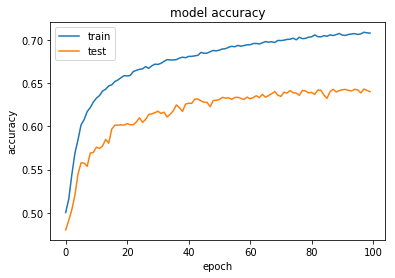

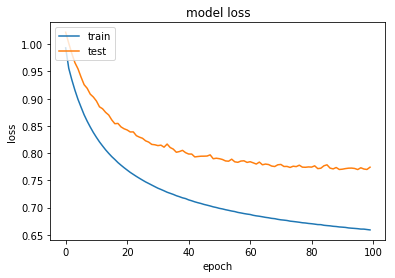

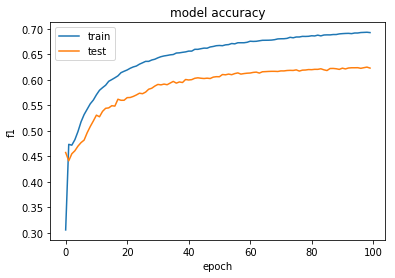

In [67]:
plot_history(history)

In [68]:
history = model.fit(en_twitter_emb, en_twitter_y, batch_size=32, epochs=50, validation_split=0.2, shuffle=True)

Train on 3392 samples, validate on 849 samples
Epoch 1/50
3392/3392 [==============================] - 1s 188us/step - loss: 0.8530 - acc: 0.6191 - f1: 0.5923 - val_loss: 0.7785 - val_acc: 0.6737 - val_f1: 0.6397
Epoch 2/50
3392/3392 [==============================] - 1s 158us/step - loss: 0.8335 - acc: 0.6291 - f1: 0.5981 - val_loss: 0.7766 - val_acc: 0.6784 - val_f1: 0.6419
Epoch 3/50
3392/3392 [==============================] - 1s 186us/step - loss: 0.8243 - acc: 0.6371 - f1: 0.6076 - val_loss: 0.7750 - val_acc: 0.6832 - val_f1: 0.6422
Epoch 4/50
3392/3392 [==============================] - 0s 143us/step - loss: 0.8150 - acc: 0.6400 - f1: 0.6130 - val_loss: 0.7600 - val_acc: 0.6879 - val_f1: 0.6552
Epoch 5/50
3392/3392 [==============================] - 1s 167us/step - loss: 0.8094 - acc: 0.6418 - f1: 0.6172 - val_loss: 0.7659 - val_acc: 0.6914 - val_f1: 0.6455
Epoch 6/50
3392/3392 [==============================] - 0s 133us/step - loss: 0.8036 - acc: 0.6442 - f1: 0.6190 - val_loss:

Epoch 50/50
3392/3392 [==============================] - 1s 259us/step - loss: 0.7092 - acc: 0.6972 - f1: 0.6776 - val_loss: 0.7463 - val_acc: 0.6726 - val_f1: 0.6496


dict_keys(['val_f1', 'val_loss', 'val_acc', 'f1', 'acc', 'loss'])


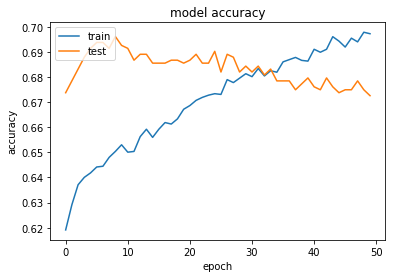

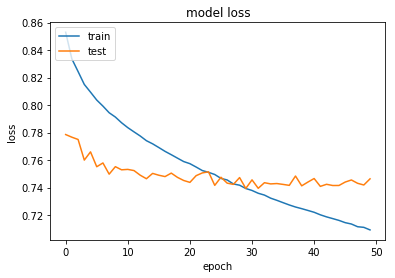

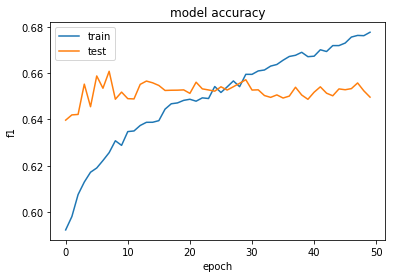

In [69]:
plot_history(history)

In [70]:
evaluate_one(model,es_tass_emb, es_tass_y)

Classification Report
              precision    recall  f1-score   support

           0       0.39      0.79      0.53      2152
           1       0.82      0.45      0.58      2883
           2       0.67      0.41      0.51      2182

   micro avg       0.54      0.54      0.54      7217
   macro avg       0.63      0.55      0.54      7217
weighted avg       0.65      0.54      0.54      7217

Confusion Matrix
[[1697  206  249]
 [1395 1289  199]
 [1213   79  890]]


In [71]:
history = model.fit(es_tass_emb, es_tass_y, batch_size=32, epochs=100, validation_split=0.1, shuffle=True)

Train on 6495 samples, validate on 722 samples
Epoch 1/100
6495/6495 [==============================] - 1s 224us/step - loss: 0.8499 - acc: 0.6106 - f1: 0.5801 - val_loss: 0.8517 - val_acc: 0.6150 - val_f1: 0.5778
Epoch 2/100
6495/6495 [==============================] - 1s 201us/step - loss: 0.8268 - acc: 0.6249 - f1: 0.5906 - val_loss: 0.8371 - val_acc: 0.6247 - val_f1: 0.5937
Epoch 3/100
6495/6495 [==============================] - 1s 159us/step - loss: 0.8167 - acc: 0.6277 - f1: 0.5963 - val_loss: 0.8311 - val_acc: 0.6288 - val_f1: 0.5950
Epoch 4/100
6495/6495 [==============================] - 1s 170us/step - loss: 0.8074 - acc: 0.6349 - f1: 0.6012 - val_loss: 0.8287 - val_acc: 0.6288 - val_f1: 0.5964
Epoch 5/100
6495/6495 [==============================] - 1s 149us/step - loss: 0.7998 - acc: 0.6397 - f1: 0.6054 - val_loss: 0.8198 - val_acc: 0.6371 - val_f1: 0.6057
Epoch 6/100
6495/6495 [==============================] - 1s 159us/step - loss: 0.7928 - acc: 0.6457 - f1: 0.6086 - val

Epoch 98/100
6495/6495 [==============================] - 1s 154us/step - loss: 0.6462 - acc: 0.7296 - f1: 0.7111 - val_loss: 0.7662 - val_acc: 0.6745 - val_f1: 0.6652
Epoch 99/100
6495/6495 [==============================] - 1s 157us/step - loss: 0.6461 - acc: 0.7316 - f1: 0.7119 - val_loss: 0.7659 - val_acc: 0.6717 - val_f1: 0.6683
Epoch 100/100
6495/6495 [==============================] - 1s 151us/step - loss: 0.6456 - acc: 0.7309 - f1: 0.7124 - val_loss: 0.7686 - val_acc: 0.6814 - val_f1: 0.6635


dict_keys(['val_f1', 'val_loss', 'val_acc', 'f1', 'acc', 'loss'])


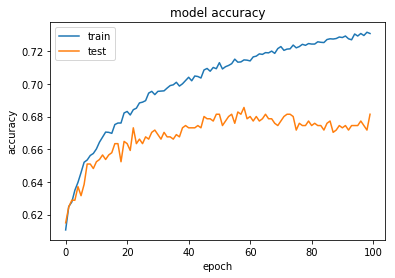

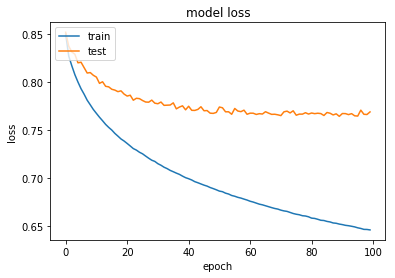

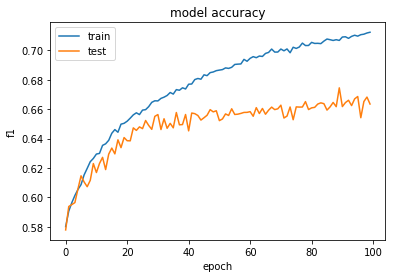

In [72]:
plot_history(history)

In [73]:
history = model.fit(es_twitter_emb, es_twitter_y, batch_size=32, epochs=50, validation_split=0.1, shuffle=True)

Train on 2881 samples, validate on 321 samples
Epoch 1/50
2881/2881 [==============================] - 0s 169us/step - loss: 0.9362 - acc: 0.5672 - f1: 0.5231 - val_loss: 0.9214 - val_acc: 0.5514 - val_f1: 0.5185
Epoch 2/50
2881/2881 [==============================] - 0s 139us/step - loss: 0.9237 - acc: 0.5741 - f1: 0.5286 - val_loss: 0.9116 - val_acc: 0.5514 - val_f1: 0.5227
Epoch 3/50
2881/2881 [==============================] - 0s 156us/step - loss: 0.9157 - acc: 0.5817 - f1: 0.5375 - val_loss: 0.9047 - val_acc: 0.5576 - val_f1: 0.5239
Epoch 4/50
2881/2881 [==============================] - 0s 166us/step - loss: 0.9096 - acc: 0.5856 - f1: 0.5408 - val_loss: 0.9065 - val_acc: 0.5732 - val_f1: 0.5237
Epoch 5/50
2881/2881 [==============================] - 1s 198us/step - loss: 0.9031 - acc: 0.5887 - f1: 0.5447 - val_loss: 0.8990 - val_acc: 0.5763 - val_f1: 0.5322
Epoch 6/50
2881/2881 [==============================] - 1s 198us/step - loss: 0.8979 - acc: 0.5932 - f1: 0.5499 - val_loss:

Epoch 50/50
2881/2881 [==============================] - 1s 200us/step - loss: 0.8055 - acc: 0.6421 - f1: 0.6085 - val_loss: 0.8726 - val_acc: 0.6044 - val_f1: 0.5450


dict_keys(['val_f1', 'val_loss', 'val_acc', 'f1', 'acc', 'loss'])


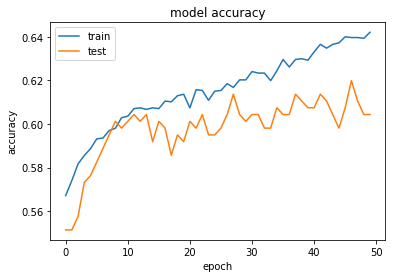

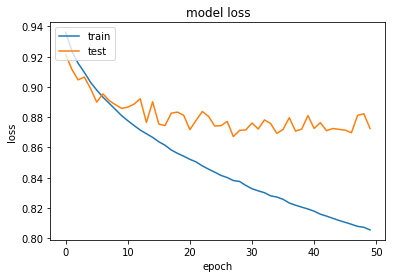

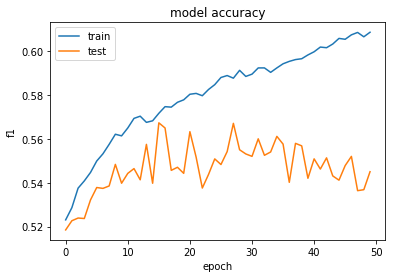

In [74]:
plot_history(history)

In [75]:
combined_emb = en_semeval_17_em.tolist().copy()
combined_emb.extend(es_twitter_emb.tolist())
combined_emb.extend(es_tass_emb.tolist())
combined_y = en_semeval_17_y.tolist().copy()
combined_y.extend(es_twitter_y.tolist())
combined_y.extend(es_tass_y.tolist())

In [76]:
combined_emb = np.array(combined_emb)
combined_y = np.array(combined_y)
combined_emb, combined_y = shuffle(combined_emb,combined_y)

In [77]:
history = model.fit(combined_emb, combined_y, batch_size=32, epochs=300, validation_data=(en_es_emb, en_es_y), shuffle=True)

Train on 31051 samples, validate on 3062 samples
Epoch 1/300
31051/31051 [==============================] - 5s 164us/step - loss: 0.7664 - acc: 0.6487 - f1: 0.6245 - val_loss: 0.8978 - val_acc: 0.5872 - val_f1: 0.5389
Epoch 2/300
31051/31051 [==============================] - 5s 168us/step - loss: 0.7509 - acc: 0.6595 - f1: 0.6349 - val_loss: 0.8834 - val_acc: 0.5983 - val_f1: 0.5523
Epoch 3/300
31051/31051 [==============================] - 6s 196us/step - loss: 0.7425 - acc: 0.6636 - f1: 0.6403 - val_loss: 0.8909 - val_acc: 0.5882 - val_f1: 0.5485
Epoch 4/300
31051/31051 [==============================] - 7s 214us/step - loss: 0.7368 - acc: 0.6665 - f1: 0.6451 - val_loss: 0.8908 - val_acc: 0.5888 - val_f1: 0.5493
Epoch 5/300
31051/31051 [==============================] - 5s 155us/step - loss: 0.7326 - acc: 0.6690 - f1: 0.6469 - val_loss: 0.8951 - val_acc: 0.5892 - val_f1: 0.5444
Epoch 6/300
31051/31051 [==============================] - 5s 169us/step - loss: 0.7293 - acc: 0.6713 - f1

Epoch 49/300
31051/31051 [==============================] - 6s 199us/step - loss: 0.7002 - acc: 0.6878 - f1: 0.6731 - val_loss: 0.8939 - val_acc: 0.5967 - val_f1: 0.5648
Epoch 50/300
31051/31051 [==============================] - 5s 149us/step - loss: 0.7000 - acc: 0.6878 - f1: 0.6719 - val_loss: 0.9017 - val_acc: 0.5927 - val_f1: 0.5548
Epoch 51/300
31051/31051 [==============================] - 5s 171us/step - loss: 0.6997 - acc: 0.6902 - f1: 0.6729 - val_loss: 0.8994 - val_acc: 0.5941 - val_f1: 0.5583
Epoch 52/300
31051/31051 [==============================] - 6s 196us/step - loss: 0.6997 - acc: 0.6899 - f1: 0.6724 - val_loss: 0.9062 - val_acc: 0.5872 - val_f1: 0.5506
Epoch 53/300
31051/31051 [==============================] - 7s 212us/step - loss: 0.6994 - acc: 0.6892 - f1: 0.6729 - val_loss: 0.9028 - val_acc: 0.5914 - val_f1: 0.5527
Epoch 54/300
31051/31051 [==============================] - 5s 167us/step - loss: 0.6994 - acc: 0.6896 - f1: 0.6736 - val_loss: 0.8996 - val_acc: 0.59

31051/31051 [==============================] - 6s 178us/step - loss: 0.6907 - acc: 0.6945 - f1: 0.6795 - val_loss: 0.9110 - val_acc: 0.5905 - val_f1: 0.5600
Epoch 146/300
31051/31051 [==============================] - 7s 226us/step - loss: 0.6906 - acc: 0.6952 - f1: 0.6799 - val_loss: 0.9123 - val_acc: 0.5908 - val_f1: 0.5605
Epoch 147/300
31051/31051 [==============================] - 5s 164us/step - loss: 0.6904 - acc: 0.6947 - f1: 0.6798 - val_loss: 0.9083 - val_acc: 0.5934 - val_f1: 0.5682
Epoch 148/300
31051/31051 [==============================] - 5s 170us/step - loss: 0.6905 - acc: 0.6945 - f1: 0.6803 - val_loss: 0.9105 - val_acc: 0.5921 - val_f1: 0.5629
Epoch 149/300
31051/31051 [==============================] - 5s 164us/step - loss: 0.6904 - acc: 0.6938 - f1: 0.6805 - val_loss: 0.9199 - val_acc: 0.5816 - val_f1: 0.5519
Epoch 150/300
31051/31051 [==============================] - 5s 168us/step - loss: 0.6903 - acc: 0.6940 - f1: 0.6800 - val_loss: 0.9145 - val_acc: 0.5849 - val

Epoch 193/300
31051/31051 [==============================] - 6s 207us/step - loss: 0.6890 - acc: 0.6945 - f1: 0.6808 - val_loss: 0.9109 - val_acc: 0.5950 - val_f1: 0.5727
Epoch 194/300
31051/31051 [==============================] - 5s 167us/step - loss: 0.6889 - acc: 0.6949 - f1: 0.6808 - val_loss: 0.9143 - val_acc: 0.5892 - val_f1: 0.5586
Epoch 195/300
31051/31051 [==============================] - 5s 171us/step - loss: 0.6889 - acc: 0.6951 - f1: 0.6814 - val_loss: 0.9131 - val_acc: 0.5914 - val_f1: 0.5620
Epoch 196/300
31051/31051 [==============================] - 5s 164us/step - loss: 0.6887 - acc: 0.6950 - f1: 0.6809 - val_loss: 0.9182 - val_acc: 0.5839 - val_f1: 0.5579
Epoch 197/300
31051/31051 [==============================] - 5s 167us/step - loss: 0.6889 - acc: 0.6950 - f1: 0.6811 - val_loss: 0.9116 - val_acc: 0.5921 - val_f1: 0.5686
Epoch 198/300
31051/31051 [==============================] - 6s 199us/step - loss: 0.6887 - acc: 0.6947 - f1: 0.6806 - val_loss: 0.9175 - val_acc

Epoch 241/300
31051/31051 [==============================] - 5s 166us/step - loss: 0.6877 - acc: 0.6952 - f1: 0.6820 - val_loss: 0.9213 - val_acc: 0.5833 - val_f1: 0.5590
Epoch 242/300
31051/31051 [==============================] - 5s 162us/step - loss: 0.6880 - acc: 0.6964 - f1: 0.6825 - val_loss: 0.9184 - val_acc: 0.5888 - val_f1: 0.5596
Epoch 243/300
31051/31051 [==============================] - 5s 162us/step - loss: 0.6878 - acc: 0.6955 - f1: 0.6818 - val_loss: 0.9165 - val_acc: 0.5908 - val_f1: 0.5636
Epoch 244/300
31051/31051 [==============================] - 5s 170us/step - loss: 0.6878 - acc: 0.6959 - f1: 0.6823 - val_loss: 0.9198 - val_acc: 0.5843 - val_f1: 0.5588
Epoch 245/300
31051/31051 [==============================] - 5s 167us/step - loss: 0.6876 - acc: 0.6957 - f1: 0.6814 - val_loss: 0.9172 - val_acc: 0.5875 - val_f1: 0.5614
Epoch 246/300
31051/31051 [==============================] - 5s 163us/step - loss: 0.6877 - acc: 0.6955 - f1: 0.6826 - val_loss: 0.9131 - val_acc

Epoch 289/300
31051/31051 [==============================] - 5s 168us/step - loss: 0.6872 - acc: 0.6954 - f1: 0.6829 - val_loss: 0.9184 - val_acc: 0.5905 - val_f1: 0.5631
Epoch 290/300
31051/31051 [==============================] - 5s 161us/step - loss: 0.6872 - acc: 0.6959 - f1: 0.6831 - val_loss: 0.9192 - val_acc: 0.5885 - val_f1: 0.5621
Epoch 291/300
31051/31051 [==============================] - 5s 161us/step - loss: 0.6874 - acc: 0.6954 - f1: 0.6824 - val_loss: 0.9204 - val_acc: 0.5856 - val_f1: 0.5606
Epoch 292/300
31051/31051 [==============================] - 5s 165us/step - loss: 0.6874 - acc: 0.6956 - f1: 0.6820 - val_loss: 0.9207 - val_acc: 0.5859 - val_f1: 0.5600
Epoch 293/300
31051/31051 [==============================] - 5s 164us/step - loss: 0.6871 - acc: 0.6965 - f1: 0.6830 - val_loss: 0.9212 - val_acc: 0.5872 - val_f1: 0.5614
Epoch 294/300
31051/31051 [==============================] - 5s 159us/step - loss: 0.6873 - acc: 0.6954 - f1: 0.6824 - val_loss: 0.9199 - val_acc

dict_keys(['val_f1', 'val_loss', 'val_acc', 'f1', 'acc', 'loss'])


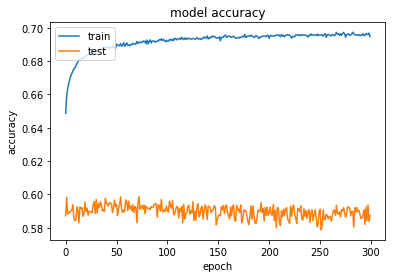

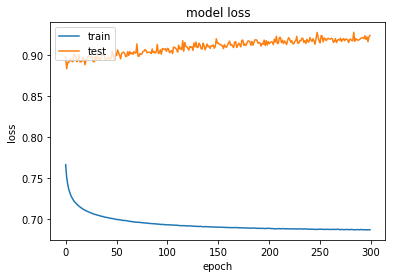

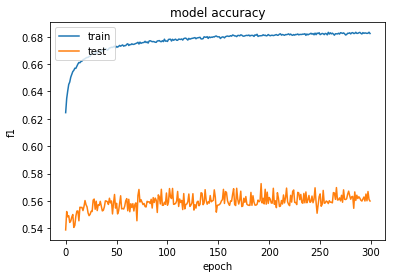

In [78]:
plot_history(history)

### model.evaluate(en_es_emb,en_es_y)

In [68]:
model.fit(en_es_emb, en_es_y, batch_size=32, epochs=30, validation_split=0.5)

Train on 1531 samples, validate on 1531 samples
Epoch 1/30
1531/1531 [==============================] - 1s 369us/step - loss: 0.4163 - acc: 0.8210 - f1: 0.8179 - val_loss: 1.0906 - val_acc: 0.6166 - val_f1: 0.6138
Epoch 2/30
1531/1531 [==============================] - 1s 357us/step - loss: 0.4494 - acc: 0.8027 - f1: 0.8071 - val_loss: 1.1192 - val_acc: 0.6120 - val_f1: 0.6108
Epoch 3/30
1531/1531 [==============================] - 1s 335us/step - loss: 0.3900 - acc: 0.8282 - f1: 0.8323 - val_loss: 1.0961 - val_acc: 0.6238 - val_f1: 0.6137
Epoch 4/30
1531/1531 [==============================] - 1s 341us/step - loss: 0.4060 - acc: 0.8282 - f1: 0.8236 - val_loss: 1.1872 - val_acc: 0.6166 - val_f1: 0.6115
Epoch 5/30
1531/1531 [==============================] - 1s 353us/step - loss: 0.3925 - acc: 0.8282 - f1: 0.8282 - val_loss: 1.1122 - val_acc: 0.6179 - val_f1: 0.6119
Epoch 6/30
1531/1531 [==============================] - 1s 360us/step - loss: 0.3761 - acc: 0.8387 - f1: 0.8337 - val_loss

In [70]:
model.evaluate(en_semeval_17_em,en_semeval_17_y)

20632/20632 [==============================] - 1s 51us/step


[0.7773272615155771, 0.7766091508336564, 0.7756524383443971]

# Load Embedding

In [20]:
import io
import numpy as np

In [21]:
## essential functions
def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [23]:
## NEED TO RUN MUSE BEFORE THIS and to get this path
# # src_path = '../vendors//MUSE/dumped/debug/4u9hakomha/vectors-en.txt'
# tgt_path = '../vendors//MUSE/dumped/debug/4u9hakomha/vectors-es.txt'
src_path = '../vendors//MUSE/dumped/6pzywzu6yg/vectors-en.txt'
tgt_path = '../vendors//MUSE/dumped/6pzywzu6yg/vectors-es.txt'
nmax = 100000  # maximum number of word embeddings to load

src_embeddings, src_id2word, src_word2id = load_vec(src_path, nmax)
tgt_embeddings, tgt_id2word, tgt_word2id = load_vec(tgt_path, nmax)

In [24]:
src_embeddings, src_id2word, src_word2id = load_vec(src_path, nmax)
tgt_embeddings, tgt_id2word, tgt_word2id = load_vec(tgt_path, nmax)

# Analysis embedding

In [25]:
def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
    print("Nearest neighbors of \"%s\":" % word)
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

In [26]:
# printing nearest neighbors in the source space
src_word = 'cat'
get_nn(src_word, src_embeddings, src_id2word, src_embeddings, src_id2word, K=5)

Nearest neighbors of "cat":
1.0000 - cat
0.7322 - cats
0.6453 - kitten
0.6381 - dog
0.6218 - kittens


In [27]:
# printing nearest neighbors in the target space
src_word = 'cat'
get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=5)

Nearest neighbors of "cat":
0.6239 - gato
0.5517 - perro
0.5393 - gatito
0.4895 - conejo
0.4846 - gorila


In [28]:
src_embeddings.shape

(100000, 300)

# Merge Embedding

In [29]:
from keras.preprocessing import sequence
from keras.utils import to_categorical

Using TensorFlow backend.


In [30]:
def merge_embeddings(src_embeddings, tgt_embeddings):
    
    # make combined embedding mattrix
    embedding_matrix = src_embeddings.copy().tolist()
    embedding_matrix.extend(tgt_embeddings.tolist())
    embedding_matrix = np.array(embedding_matrix)
    
    # make combined id2word and word2id
    id2word = src_id2word.copy()
    word2id = src_word2id.copy()
    
    next_id = len(id2word.keys())
    counter = len(id2word.keys())
    
    to_be_removed_id = []
    common_words = []
    
    for key in tgt_id2word:
        if tgt_id2word[key] in word2id:
            to_be_removed_id.append(counter)
            common_words.append(tgt_id2word[key])
            embedding_matrix[word2id[tgt_id2word[key]]] =  (embedding_matrix[word2id[tgt_id2word[key]]] + embedding_matrix[counter])/2
        else:
            id2word[next_id] = tgt_id2word[key]
            word2id[tgt_id2word[key]] = next_id
            next_id += 1
        counter += 1
        
    embedding_matrix = np.delete(embedding_matrix, to_be_removed_id, axis=0)
        
    return embedding_matrix, id2word, word2id, common_words

In [31]:
embedding_matrix, id2word, word2id, common_words = merge_embeddings(src_embeddings, tgt_embeddings)

In [32]:
print("embedding size: ", str(embedding_matrix.shape))

embedding size:  (161832, 300)


In [33]:
print("Number of common words in both the embedding %d" % len(common_words))

Number of common words in both the embedding 38168


In [34]:
# ADD UNK
# TODO:

# Data Preprocess Part 2

In [38]:
from  nltk.stem import SnowballStemmer

In [39]:
MAX_SEQUENCE_LENGTH = 20

In [40]:
words_not_found = 0
def from_datas_to_x_y(list_data, word2id, max_seq_len=20, max_classes=3, seed=0):
    stemmer = SnowballStemmer("english")  
    words_not_found = 0
    def to_x(sample):
        global words_not_found
        x = []
        for word in sample['tokens']:
            # lower the word 
            word = word.lower()
            if word in word2id:
                x.append(word2id[word]) 
            else:
                stem = stemmer.stem(word) # find stem
                if stem in word2id:
                    x.append(word2id[stem])
                else:
                    words_not_found = words_not_found + 1
                    pass
        return x

    def to_x_y(data):
        temp =  np.array(list(map(lambda x : [to_x(x), x['sentiment']], data)))
        x = list(sequence.pad_sequences(temp[:,0], maxlen=max_seq_len))
        y = list(to_categorical(temp[:,1],num_classes=max_classes))
        return x, y
    
    x,y = [],[]
    for data in list_data:
        x_, y_ = to_x_y(data)
        print("x: %d \t y: %d" % (len(x_),len(y_)))
        x.extend(x_)
        y.extend(y_)
    x = np.array(x)
    y = np.array(y)
    x,y = shuffle(x, y, replace=True)
    
    print("Not Found words = %f" % (float(words_not_found)/(x.shape[0])))
    return x,y

In [41]:
# x_test,y_test = from_datas_to_x_y([en_es_wssa_data],word2id)

In [45]:
def evaluate_one(model, x, y):
    y_pred = model.predict(x,verbose=0)
    print("Classification Report")
    print(classification_report(np.argmax(y, axis=1), np.argmax(y_pred,axis=1)))
    print("Confusion Matrix")
    print(confusion_matrix(np.argmax(y, axis=1), np.argmax(y_pred,axis=1)))
def evaluate(model):
    print("Code Mixed: ")
    x_test,y_test = from_datas_to_x_y([en_es_wssa_data],word2id)
    evaluate_one(model, x_test, y_test)
    
    print("\nEnglish: divam")
    x_test,y_test = from_datas_to_x_y([en_twitter_data],word2id)
    evaluate_one(model, x_test, y_test)
    
    print("\nEnglish: semeval")
    x_test,y_test = from_datas_to_x_y([en_semeval_17],word2id)
    evaluate_one(model, x_test, y_test)
    
    print("\nSpanish: 1")
    x_test,y_test = from_datas_to_x_y([es2_twitter_data],word2id)
    evaluate_one(model, x_test, y_test)
    
    print("\nSpanish: 2")
    x_test,y_test = from_datas_to_x_y([es_tass1_data],word2id)
    evaluate_one(model, x_test, y_test)

In [43]:
# print(x.shape)
# print(y.shape)

# Base Model

In [44]:
from keras.layers import *
from keras.models import Sequential

In [45]:
#embedding
EMBEDDING_DIM = embedding_matrix.shape[1] 
MAX_NUM_WORDS = embedding_matrix.shape[0]

In [85]:
# for cnn_lstm

# Convolution
kernel_size = 5
filters = 64
pool_size = 1
# lstm
lstm_output_size = 70

In [47]:
model = Sequential()
model.add(Embedding(MAX_NUM_WORDS,
                     EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=True))
# model.add(Dropout(0.2))
# model.add(Conv1D(filters,
#                  kernel_size,
#                  activation='relu',
#                  strides=1))
# model.add(MaxPooling1D(pool_size=pool_size))
# model.add(LSTM(lstm_output_size))
model.add(Bidirectional(LSTM(512, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1])

In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 300)           48549600  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1024)              3330048   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 51,882,723
Trainable params: 51,882,723
Non-trainable params: 0
_________________________________________________________________


In [99]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor='val_f1', patience=4, restore_best_weights=True, mode="max", verbose=5)
checkpointer = ModelCheckpoint(filepath='weights.{epoch:02d}-{val_f1:.2f}.hdf5', verbose=1, save_best_only=True, save_weights_only=True, monitor='val_f1')

# Just english

In [49]:
x_train, y_train = from_datas_to_x_y([en_semeval_17,en_twitter_data],word2id)

x: 20632 	 y: 20632
x: 4241 	 y: 4241
Not Found words = 0.000000


In [50]:
get_class_weight(y_train)

{0: 0.6743940133398406, 1: 0.9871413263483748, 2: 1.9834928229665072}

In [51]:
history = model.fit(x_train , y_train, 
                    epochs=8, 
                    batch_size=128,
                    validation_split=0.3, 
                    shuffle=True)

Train on 17411 samples, validate on 7462 samples
Epoch 1/8
17411/17411 [==============================] - 28s 2ms/step - loss: 0.8944 - acc: 0.5773 - f1: 0.5176 - val_loss: 0.8849 - val_acc: 0.5821 - val_f1: 0.4813
Epoch 2/8
17411/17411 [==============================] - 21s 1ms/step - loss: 0.7512 - acc: 0.6614 - f1: 0.6359 - val_loss: 0.7612 - val_acc: 0.6593 - val_f1: 0.6249
Epoch 3/8
17411/17411 [==============================] - 21s 1ms/step - loss: 0.6359 - acc: 0.7236 - f1: 0.7146 - val_loss: 0.7562 - val_acc: 0.6654 - val_f1: 0.6485
Epoch 4/8
17411/17411 [==============================] - 21s 1ms/step - loss: 0.5488 - acc: 0.7681 - f1: 0.7632 - val_loss: 0.8585 - val_acc: 0.6600 - val_f1: 0.6554
Epoch 5/8
17411/17411 [==============================] - 21s 1ms/step - loss: 0.4671 - acc: 0.8084 - f1: 0.8060 - val_loss: 0.8928 - val_acc: 0.6412 - val_f1: 0.6333
Epoch 6/8
17411/17411 [==============================] - 22s 1ms/step - loss: 0.3699 - acc: 0.8532 - f1: 0.8520 - val_los

KeyboardInterrupt: 

In [52]:
evaluate(model)

Code Mixed: 
x: 3062 	 y: 3062
Not Found words = 0.000000
Classification Report
              precision    recall  f1-score   support

           0       0.49      0.70      0.57      1313
           1       0.55      0.41      0.47       963
           2       0.52      0.31      0.38       786

   micro avg       0.51      0.51      0.51      3062
   macro avg       0.52      0.47      0.48      3062
weighted avg       0.51      0.51      0.49      3062

Confusion Matrix
[[913 237 163]
 [505 396  62]
 [454  92 240]]

English: divam
x: 4241 	 y: 4241
Not Found words = 0.000000
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1952
           1       0.81      0.85      0.83      1340
           2       0.86      0.71      0.78       949

   micro avg       0.82      0.82      0.82      4241
   macro avg       0.83      0.81      0.82      4241
weighted avg       0.83      0.82      0.82      4241

Confusion Ma

# Just Spanish

In [53]:
x_train_es, y_train_es =  from_datas_to_x_y([es_tass1_data, es2_twitter_data], word2id=word2id)

x: 7217 	 y: 7217
x: 3202 	 y: 3202
Not Found words = 0.000000


In [54]:
get_class_weight(y_train_es)

{0: 1.0385765550239234, 1: 0.8748110831234257, 2: 1.1185185185185185}

In [55]:
history = model.fit(x_train_es, y_train_es, 
                    epochs=10, 
                    batch_size=128, 
                    validation_split=0.1, 
                    shuffle=True)

Train on 9377 samples, validate on 1042 samples
Epoch 1/10
9377/9377 [==============================] - 11s 1ms/step - loss: 0.9773 - acc: 0.5555 - f1: 0.4848 - val_loss: 0.8473 - val_acc: 0.6161 - val_f1: 0.5543
Epoch 2/10
9377/9377 [==============================] - 11s 1ms/step - loss: 0.6006 - acc: 0.7534 - f1: 0.7399 - val_loss: 0.9064 - val_acc: 0.6065 - val_f1: 0.5822
Epoch 3/10
9377/9377 [==============================] - 11s 1ms/step - loss: 0.3773 - acc: 0.8582 - f1: 0.8561 - val_loss: 1.1155 - val_acc: 0.5806 - val_f1: 0.5737
Epoch 4/10
5120/9377 [===============>..............] - ETA: 4s - loss: 0.2226 - acc: 0.9184 - f1: 0.9193

KeyboardInterrupt: 

In [56]:
evaluate(model)

Code Mixed: 
x: 3062 	 y: 3062
Not Found words = 0.000000
Classification Report
              precision    recall  f1-score   support

           0       0.54      0.50      0.52      1313
           1       0.49      0.58      0.53       963
           2       0.49      0.43      0.46       786

   micro avg       0.51      0.51      0.51      3062
   macro avg       0.50      0.50      0.50      3062
weighted avg       0.51      0.51      0.51      3062

Confusion Matrix
[[662 417 234]
 [291 556 116]
 [279 172 335]]

English: divam
x: 4241 	 y: 4241
Not Found words = 0.000000
Classification Report
              precision    recall  f1-score   support

           0       0.80      0.79      0.80      1952
           1       0.74      0.86      0.79      1340
           2       0.84      0.67      0.75       949

   micro avg       0.79      0.79      0.79      4241
   macro avg       0.79      0.77      0.78      4241
weighted avg       0.79      0.79      0.78      4241

Confusion Ma

## Both English and Spanish

In [57]:
x_train_both, y_train_both = from_datas_to_x_y([en_twitter_data, en_semeval_17, es2_twitter_data, es_tass1_data],word2id)

x: 4241 	 y: 4241
x: 20632 	 y: 20632
x: 3202 	 y: 3202
x: 7217 	 y: 7217
Not Found words = 0.000000


In [58]:
x_test,y_test = from_datas_to_x_y([en_es_wssa_data],word2id)

x: 3062 	 y: 3062
Not Found words = 0.000000


In [59]:
model.fit(x_train_both,y_train_both,
          validation_data=(x_test,y_test),
          batch_size=128,
          epochs=10,
          shuffle=True)

Train on 35292 samples, validate on 3062 samples
Epoch 1/10
35292/35292 [==============================] - 40s 1ms/step - loss: 0.4548 - acc: 0.8275 - f1: 0.8261 - val_loss: 1.1764 - val_acc: 0.5206 - val_f1: 0.5062
Epoch 2/10
35292/35292 [==============================] - 41s 1ms/step - loss: 0.3077 - acc: 0.8844 - f1: 0.8844 - val_loss: 1.4464 - val_acc: 0.5039 - val_f1: 0.4923
Epoch 3/10
 6272/35292 [====>.........................] - ETA: 31s - loss: 0.2118 - acc: 0.9235 - f1: 0.9228

KeyboardInterrupt: 

In [ ]:
evaluate(model)

# Cross-Lingual

In [73]:
def plot_history(history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['f1'])
    plt.plot(history.history['val_f1'])
    plt.title('model accuracy')
    plt.ylabel('f1')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [39]:
from keras import backend as K


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [40]:
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
def get_class_weight(y):
    """
    Used from: https://stackoverflow.com/a/50695814
    TODO: check validity and 'balanced' option
    :param y: A list of one-hot-encoding labels [[0,0,1,0],[0,0,0,1],..]
    :return: class-weights to be used by keras model.fit(.. class_weight="") -> {0:0.52134, 1:1.adas..}
    """
    y_integers = np.argmax(y, axis=1)
    class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
    d_class_weights = dict(enumerate(class_weights))
    return d_class_weights

In [41]:
# doesn't work

In [29]:
from dlblocks import text
from dlblocks.pyutils import mapArrays , loadJson , saveJson , selectKeys , oneHotVec , padList
from dlblocks.pyutils import int64Arr , floatArr

In [ ]:
vocab = text.Vocabulary()

for d in es_tass1_data + en_es_wssa_data + en_twitter_data + es2_twitter_data :
    vocab.add_words( d['tokens']  )

    
vocab.keepTopK(25000)



maxSentenceL = 150

def vecc( d ):
    ret = {}
    words   = d['tokens']
    wordids = map( vocab , words )
    ret['sentence'] = int64Arr( padList( wordids , maxSentenceL , 0 , 'left') )
    ret['sentiment_val'] =  floatArr( d['sentiment'] )
    ret['sentiment_id'] =  int64Arr( d['sentiment'] + 1 )
    ret['sentiment_onehot'] =  floatArr( oneHotVec( d['sentiment']+1 , 3  ) )

    return ret





en_es_wssa_data_train_arr = mapArrays( en_es_wssa_data_train , vecc )
en_es_wssa_data_test_arr = mapArrays( en_es_wssa_data_test , vecc )

en_twitter_data_train_arr = mapArrays( en_twitter_data , vecc )
es_tass1_datatrain_arr = mapArrays( es_tass1_data , vecc )

datasets = {"en_es_wssa_data_train_arr":en_es_wssa_data_train_arr ,
           "en_es_wssa_data_test_arr":en_es_wssa_data_test_arr ,
           "en_twitter_data_train_arr":en_twitter_data_train_arr ,
           "es_tass1_datatrain_arr": es_tass1_datatrain_arr }



outFNN = "../data/senti_prepped.h5"

f = h5py.File(outFNN , "w")
for kk in datasets.keys():
    f.create_group( kk  )
    for k in datasets[kk].keys():
        f[ kk ].create_dataset( k , data=datasets[kk][k] )

print "HDF5 file created !"